In [0]:
from __future__ import division, print_function, absolute_import
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [0]:
import numpy as np

def feat(image):
    tf.reset_default_graph()

    #kernel_h = np.array([3, 3])
    kernel_h = [ 
        [-1, 0, 1], 
        [-1, 0, 1],
        [-1, 0, 1]]
    kernel_v = [ 
        [-1, 0, -1], 
        [-1, 0, -1],
        [-1, 0, -1]]
    input_placeholder_h = tf.placeholder(
        dtype=tf.float32, shape=(1, image.shape[0], image.shape[1], 1))
    input_placeholder_v = tf.placeholder(
        dtype=tf.float32, shape=(1, 14, 14, 1))
    
    
    with tf.name_scope('convolution'):
        conv_w_h = tf.constant(kernel_h, dtype=tf.float32, shape=(3, 3, 1, 1)) 
        output_h = tf.nn.conv2d(input=input_placeholder_h, filter=conv_w_h, strides=[1, 2, 2, 1], padding='SAME', use_cudnn_on_gpu=True)

        conv_w_v = tf.constant(kernel_v, dtype=tf.float32, shape=(3, 3, 1, 1)) 
        output_v = tf.nn.conv2d(input=input_placeholder_v, filter=conv_w_v, strides=[1, 2, 2, 1], padding='SAME', use_cudnn_on_gpu=True)
        
    with tf.Session() as sess:
        result_h = sess.run(output_h, feed_dict={
            input_placeholder_h: image[np.newaxis, :, :, np.newaxis]
        })
        res = result_h[0, :, :, 0]
        result_v = sess.run(output_v, feed_dict={
            input_placeholder_v: res[np.newaxis, :, :, np.newaxis]
        })
        return result_h

In [0]:
import matplotlib.pyplot as plt
#%matplotlib inline

from ipywidgets import IntProgress
from IPython.display import display

max_count = len(mnist.train.images[:1000]) + len(mnist.test.images[:1000])
f = IntProgress(min=0, max=max_count) # instantiate the bar
display(f) # display the bar

def extract_features(dataset):    
    features = []
    for i in range(len(dataset)):
        f.value += 1
        feature = []
        img = dataset[i]
        img.shape = (28, 28)
        result = feat(img)
        new_feature = []
        for res in result[0, :, :, 0]:
            for val in res:
                new_feature.append(val)
        features.append(new_feature)
        
    return features



IntProgress(value=0, max=2000)

In [0]:
new_train_features = extract_features(mnist.train.images[:1000])
new_test_features = extract_features(mnist.test.images[:1000])


train_labels = mnist.train.labels[:1000]
test_labels = mnist.test.labels[:1000]


In [0]:
#shuffling arrays
import random
own_features = [*new_train_features[:1000], *new_test_features[:1000]]
own_labels= [*train_labels[:1000],*test_labels[:1000]]
test_features = mnist.test.images[:1000]
train_features = mnist.train.images[:1000]
no_extraction_features = [*train_features[:1000], *test_features[:1000]]


def shuffle_features_and_labels(features,labels):
  merged_arrays= list(zip(features,labels))
  random.shuffle(merged_arrays)
  return zip(*merged_arrays)


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5411765, 0.3803922, 0.0, 0.0, 0.43921572, 0.09803921, -0.537255, -0.83921576, -0.08235294, 0.0, 0.0, 0.0, 0.0, 1.4352942, 0.9176471, 0.34509808, 0.0, -0.54117656, 0.062745094, 0.011764705, 0.55686283, -0.9686276, -1.737255, -0.08235294, 0.0, 0.0, 0.0, 1.0352942, -0.16862744, -0.08627451, 0.0, -0.54117656, 0.0, 0.0, 0.7647059, 1.9843138, -1.537255, -1.4509805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4156863, 2.572549, -0.19999999, -2.7882354, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4666667, 0.98823535, 0.43529415, 0.5137255, 0.58431375, -0.043137312, -2.9450982, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4431373, 1.2862746, 0.6235295, -0.011764735, -0.5372549, -0.5137255, 1.3333335, 0.31372547, -2.9372551, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1764706, 0.50980395, -0.79607844, -0.54117656,

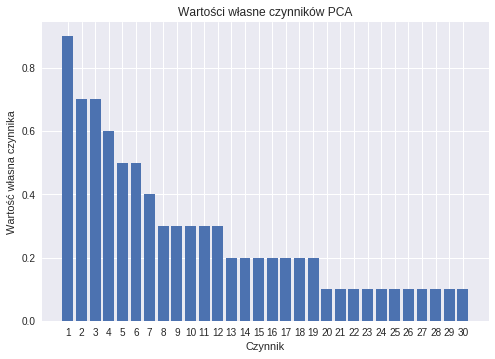

In [0]:
#pca graph

from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
pca = PCA(n_components=30)
print(own_features)
pca.fit(own_features)
pca_data = pca.transform(own_features)
per_var=np.round(pca.explained_variance_ratio_*10, decimals=1)
labels = [str(x) for x in range (1, len(per_var)+1)]
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Wartość własna czynnika')
plt.xlabel('Czynnik')
plt.title("Wartości własne czynników PCA")
plt.show()


In [0]:
#cross validation


from sklearn.decomposition import PCA
import pandas as pd
n_estimators= [10,20,50,100,200,500]
for estimator in n_estimators:
  scores =[]
  for i in range(0,10):
    features, labels = shuffle_features_and_labels(own_features,own_labels) # change own_features, to no_extraction_features for no cnn extraction
    kf = KFold(n_splits=2)
    rfc= RandomForestClassifier(estimator)
    pca = PCA(n_components=100) 
    features =  StandardScaler().fit_transform(features) # comment for no normalization
    features = pca.fit_transform(features)#comment for no pca

    scores.append(np.mean(cross_val_score(rfc,features,labels,cv=2)))
  print( str(estimator)+": " + str(np.mean(scores)))

10: 0.6002959002959003
20: 0.6821504321504321
50: 0.7536556036556037
100: 0.7765054765054765
200: 0.7962485462485461


KeyboardInterrupt: ignored